# Data Pre-Process

This contains our code to extract the WLASL100 and process the videos into numpy arrays and glosses into integer labels

* Filters out the WLASL100 videos
* WLASL1100_parsed_data.json: a json of video objects with elements
    * "gloss": a str of the signed word,
    * "label": an int label corresponding to the gloss,
    * "video_path": a str of the path of the video from current directory
    * "frame_start": an int of the frame where the signing starts,
    * "frame_end": an int of the frame where the signing ends,
    * "split": a str of the subset which is either "train" "val" or "test"


References:
* https://www.kaggle.com/code/abd0kamel/mutemotion-wlasl-translation-model
* https://openaccess.thecvf.com/content/WACV2022W/HADCV/papers/Bohacek_Sign_Pose-Based_Transformer_for_Word-Level_Sign_Language_Recognition_WACVW_2022_paper.pdf

### Import Data and Libraries
* Define base_path, the file path where the videos, landmarks, data files are stored
* Import existing label and json files describing the WLASL dataset

In [1]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import FileLink

In [3]:
'''
Modify variables for respective computer
Rena: 'wlasl
Esther: '/Users/esther/Downloads/archive'
'''
base_path = 'wlasl'

'''
n determines number of glosses we wish to extract
'''
n = 100

In [121]:
# create a label dictionary that maps the gloss to the label integer 
# for the first n glosses

with open(f'{base_path}/wlasl_class_list.txt') as file:
  lines = file.readlines()

label_dict = {}
for i in range(n):
  index, label = lines[i].strip().split('\t')
  label_dict[label] = int(index)

len(label_dict.items())

100

In [122]:
with open(f'{base_path}/WLASL_v0.3.json', 'r') as json_file:
    all_data = json.load(json_file)

print(len(all_data)) # number glosses total
print(len(all_data[0]['instances'])) # number instances of first gloss

2000
40


### Filter the Videos

* Define a new path for the video instances of the top n glosses
* Move videos to new path
* Defie a new json storing necessary metadata of video instances of the top n glosses

In [127]:
video_dir = f'{base_path}/videos'
filt_video_dir = f'{base_path}/videos{n}'
os.makedirs(filt_video_dir, exist_ok=True)

wlasl/videos


In [146]:
'''
A function for processing the video instances of the top n glosses
by moving them to a separate folder and redefining a dictionary

Params:
    n: an int of the number of glosses desired
Returns:
    a list of video objects
        data: a list
        data[i] = {'gloss': str, 'label': int, 'video_path': str, 'frame_start': int, 'frame_end': int, 'split': str} 
        data[i][field] = value

'''
def filter_videos(n):
    data = []
    # iterate over first n glosses in all_data
    glosses = [entry['gloss'] for entry in all_data[:n]]
    all_instances = [entry['instances'] for entry in all_data[:n]]

    for i, gloss in enumerate(glosses):
        for instance in all_instances[i]:

            # find the video
            video_id = instance["video_id"]
            video_path = os.path.join(filt_video_dir, f'{video_id}.mp4')
            if os.path.exists(os.path.join(video_dir, f'{video_id}.mp4')):
                # move video to new folder
                source_path = os.path.join(video_dir, f'{video_id}.mp4')
                video_path = shutil.move(source_path, filt_video_dir)
            
            # if video was successfully moved
            if os.path.exists(video_path):
                # extract all the metadata information provided and append to dictionary
                frame_start = instance['frame_start']
                frame_end = instance['frame_end']
                split = instance['split']
                bbox = instance['bbox']
                data.append({
                    'gloss': gloss,
                    'label': label_dict[gloss],
                    'bbox': bbox,
                    'video_id': video_id,
                    'video_path': video_path,
                    'frame_start': frame_start,
                    'frame_end': frame_end,
                    'split': split
                })

    return data    


In [147]:
parsed_data = filter_videos(n)
with open(f'{base_path}/WLASL{n}_parsed_data.json', 'w') as json_file:
    json.dump(parsed_data, json_file, indent=4)

FileLink(rf'{base_path}/WLASL{n}_parsed_data.json')

/Users/renabi/Academia/2024 Spring/Computer Vision/asl-recognition/wlasl/WLASL100_parsed_data.json

### Visualize Our Data

* Plot of frequency of each gloss

In [4]:
with open(f'{base_path}/WLASL{n}_parsed_data.json', 'r') as json_file:
    parsed_data = json.load(json_file)

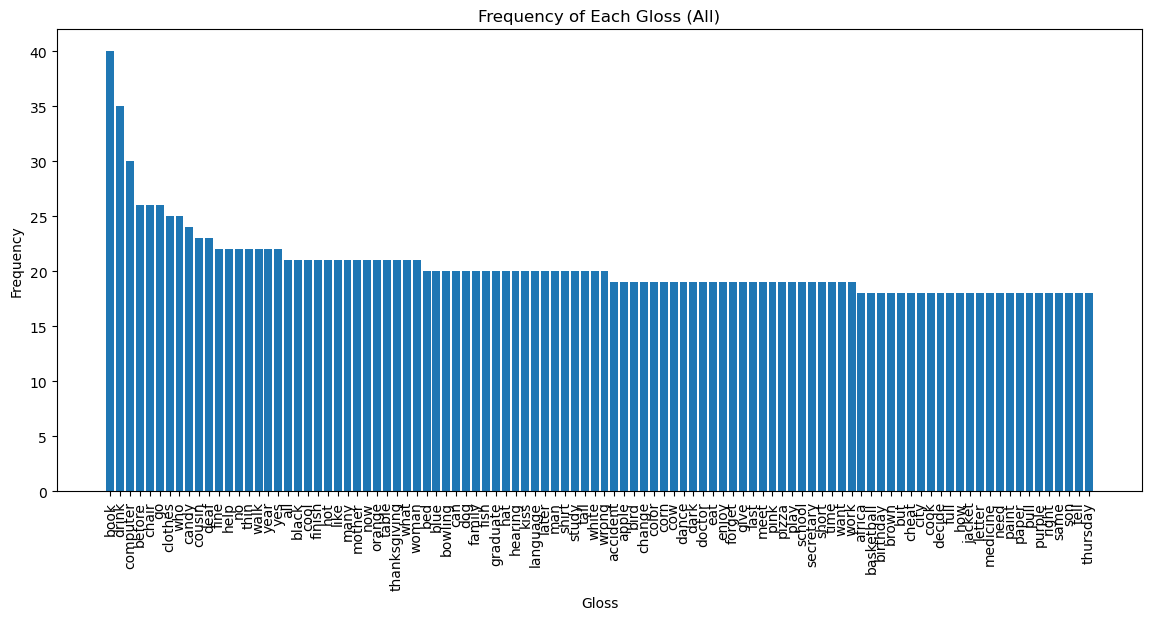

2038


In [5]:
from collections import Counter

# extract array of the gloss of each instance
data_glosses = [parsed_data[i]['gloss'] for i in range(len(parsed_data))]

# feed array through counter to determine frequencies and categories
gloss_counter = Counter(data_glosses)
glosses = list(gloss_counter.keys())
gloss_counts = list(gloss_counter.values())

# plot
plt.figure(figsize=(14, 6))
plt.bar(glosses, gloss_counts)
plt.title('Frequency of Each Gloss (All)')
plt.xlabel('Gloss')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')

# Show the plot
plt.show()

print(np.sum(gloss_counts))

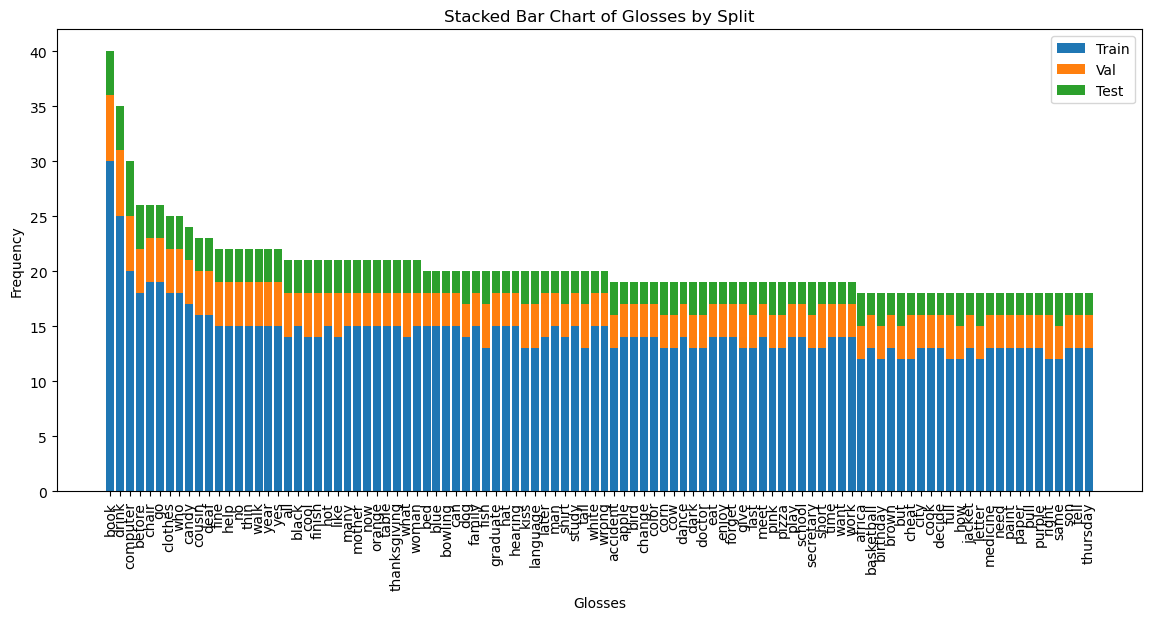

In [17]:
# count glosses per split
train_counts = {}
val_counts = {}
test_counts = {}

for data in parsed_data:
    gloss = data['gloss']
    split = data['split']
    if split == 'train':
        train_counts[gloss] = train_counts.get(gloss, 0) + 1
    elif split == 'val':
        val_counts[gloss] = val_counts.get(gloss, 0) + 1
    elif split == 'test':
        test_counts[gloss] = test_counts.get(gloss, 0) + 1

# convert counts to lists
train_counts = [train_counts.get(gloss, 0) for gloss in glosses]
val_counts = [val_counts.get(gloss, 0) for gloss in glosses]
test_counts = [test_counts.get(gloss, 0) for gloss in glosses]

# plot stacked bar chart
plt.figure(figsize=(14, 6))
plt.bar(glosses, train_counts, label='Train')
plt.bar(glosses, val_counts, bottom=train_counts, label='Val')
plt.bar(glosses, test_counts, bottom=[train + val for train, val in zip(train_counts, val_counts)], label='Test')

# add labels, title, and legend
plt.xlabel('Glosses')
plt.ylabel('Frequency')
plt.title('Stacked Bar Chart of Glosses by Split')
plt.xticks(rotation='vertical')
plt.legend()

# Show plot
plt.show()

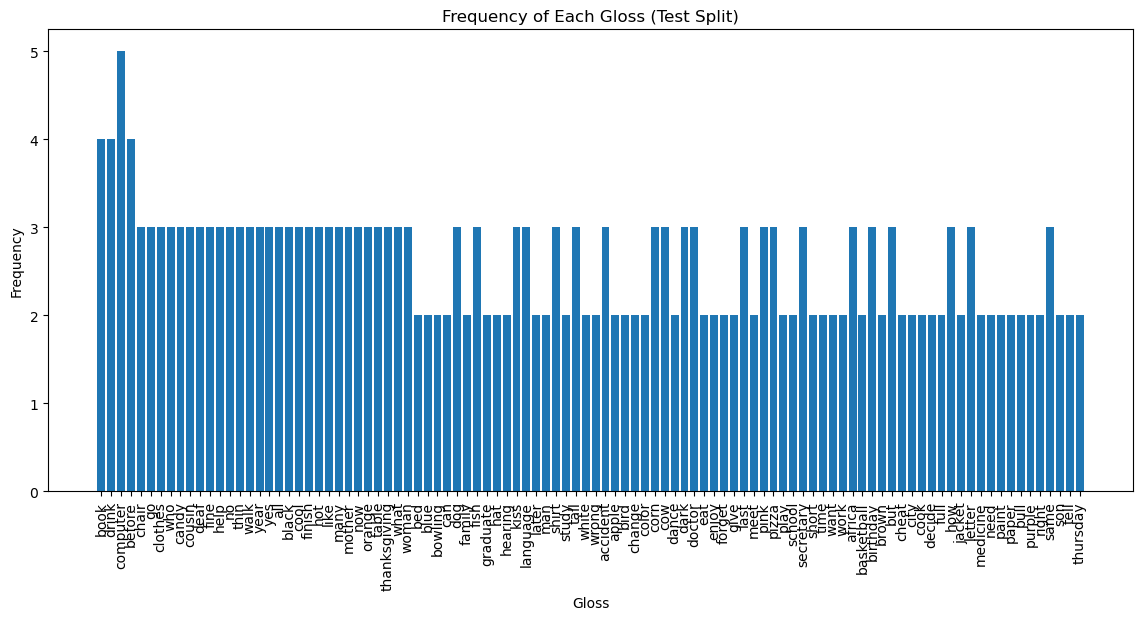

2038


In [7]:
from collections import Counter

# extract array of the gloss of each instance
parsed_data_test = [parsed_data[i] for i in range(len(parsed_data)) if parsed_data[i]['split'] == 'test']

data_glosses_test = [parsed_data_test[i]['gloss'] for i in range(len(parsed_data_test))]

# feed array through counter to determine frequencies and categories
gloss_counter_test = Counter(data_glosses_test)
glosses_test = list(gloss_counter_test.keys())
gloss_counts_test = list(gloss_counter_test.values())

# plot
plt.figure(figsize=(14, 6))
plt.bar(glosses_test, gloss_counts_test)
plt.title('Frequency of Each Gloss (Test Split)')
plt.xlabel('Gloss')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')

# Show the plot
plt.show()

print(np.sum(gloss_counts))

In [ ]:
from collections import Counter

# extract array of the gloss of each instance
parsed_data_val = [parsed_data[i] for i in range(len(parsed_data)) if parsed_data[i]['split'] == 'val']

data_glosses_val = [parsed_data_val[i]['gloss'] for i in range(len(parsed_data_val))]

# feed array through counter to determine frequencies and categories
gloss_counter_val = Counter(data_glosses_val)
glosses_val = list(gloss_counter_val.keys())
gloss_counts_val = list(gloss_counter_val.values())

# plot
plt.figure(figsize=(14, 6))
plt.bar(glosses_test, gloss_counts_test)
plt.title('Frequency of Each Gloss (Test Split)')
plt.xlabel('Gloss')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')

# Show the plot
plt.show()

print(np.sum(gloss_counts))

### Visual Bounding Box

In [184]:
vid_inst = parsed_data[3] # a random video instance
vid_inst

{'gloss': 'book',
 'label': 0,
 'bbox': [123, 19, 516, 358],
 'video_id': '68208',
 'video_path': 'wlasl/videos100/68208.mp4',
 'frame_start': 1,
 'frame_end': 60,
 'split': 'train'}

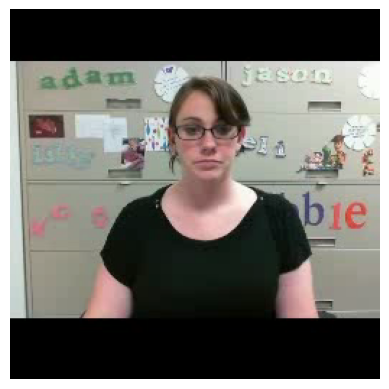

In [185]:
import cv2
import matplotlib.pyplot as plt

video_id = vid_inst['video_id']
video_path = f'wlasl/videos100/{video_id}.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
frame.flags.writeable = False
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame)
plt.axis('off')
plt.show()

cap.release()


256 256
123 19 516 358


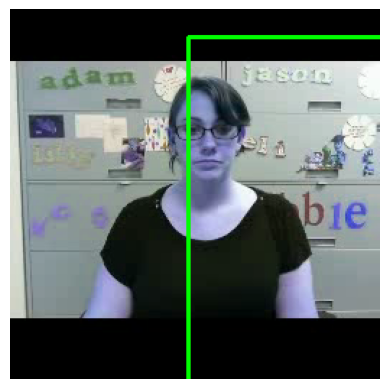

In [186]:
height, width, _ = frame.shape
print(height,width)

x1, y1, x2, y2 = vid_inst['bbox']  # Unpack bbox coordinates
print(x1,y1,x2,y2)

# Draw the bounding box rectangle
cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(frame[:,:,::-1])
plt.axis('off')
plt.show()